# GPT-3.5 vs GPT-4 vs ChatXML vs ChatXML w/ CoT
This notebook uses the infinite loop match eval from the OpenAI eval repo to test various models and prompt methods. Nothing about this analysis is very comprehensive but I do think it will serve as a useful playground for those who want to experiment with structured prompting and quantitative prompt evaluation. 

The OpenAI evals are supposed to be topics that GPT-4 struggles with so the performance is relatively poor across all examples. 

Here's a table summarizing the  results:

| Model                 | Precision | Recall | F1-score | Accuracy |
|-----------------------|-----------|--------|----------|----------|
| Raw GPT-3.5           | 0.41      | 0.70   | 0.36     | 0.52     |
| Raw GPT-4             | 0.74      | 0.72   | 0.68     | 0.53     |
| ChatXML GPT-3.5       | 0.41      | 0.67   | 0.36     | 0.50     |
| ChatXML with GPT-4    | 0.42      | 0.73   | 0.35     | 0.54     |
| ChatXML with GPT-4 and COT | 0.39 | 0.71   | 0.38     | 0.56     |
| Claude-V1.3 and COT                | 0.75      | 0.76   | 0.75     | 0.63     |

This table includes the macro average values for Precision, Recall, F1-score, and Accuracy for each example. Based on these values, you can make a decision about the effectiveness of each score.

The table above shows the classification performance of six different models on a classification dataset. The models are evaluated based on precision, recall, F1-score, and accuracy. 

Overall, it can be observed that the models have varying levels of effectiveness in their classification performance. The Claude model performs the best with an F1-score of 0.75, followed by the ChatXML with GPT-4 with an F1-score of 0.68. The Raw GPT-3.5 model has the lowest F1-score of 0.36. 

Still at the end of the day, the models struggle to do much better than random! I only looked through a few of the evals but I was surprised how badly written many of them are. I did not do a detailed review of the infinite loop set but I did find a few that looked ambigious to me but for the most part it looked like a good set.

To be honest, I was hoping the evidence in favor of ChatXML would be more comprehensive. However, this analysis shows that while there are performance gains to be had, they probably don't warrant the additional tokens and latency that it costs in this case. I plan to do this exercise on mutliple evals in the near future to establish some quantitative prompt engineering results.

### Warning!
This notebook cost about $5 in API calls so be ready and be careful!

In [183]:
import json
import pandas as pd
def xmlify(messages):
    xml = ''
    for message in messages:
        xml += f'<message><source>{message["role"]}</source><content>{message["content"]}</content></message>'

    xml = f'<input>{xml}</input>'
    return xml

from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain.chat_models import ChatOpenAI
def no_prompt_complete(messages, model_params):
    chatbot = ChatOpenAI(**model_params)
    request_message = []
    for message in messages:
        if message['role'] == 'user':
            formated_message = HumanMessage(content=message['content'])
        elif message['role'] == 'system':
            formated_message = SystemMessage(content= message['content'])
        elif message['role'] == 'assistant':
            formated_message = AIMessage(content= message['content'])
        request_message.append(formated_message)
    response = chatbot(request_message)
    return response.content

In [62]:
file = 'data\infiniteloop-match.jsonl'
with open(file) as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]

df = pd.DataFrame(lines)
df.head()

,input,ideal
0,"[{'role': 'system', 'content': 'You have to de...",False
1,"[{'role': 'system', 'content': 'You have to de...",True
2,"[{'role': 'system', 'content': 'You have to de...",True
3,"[{'role': 'system', 'content': 'You have to de...",True
4,"[{'role': 'system', 'content': 'You have to de...",True


In [63]:
def extract(result):
    result = result.lower()
    if 'true' in result:
        return 'True'
    elif 'false' in result:
        return 'False'
    else:
        return 'no answer'
target_names = {0: 'False', 1: 'True', 3: 'no answer'}

In [64]:
target_numbers = {v: k for k, v in target_names.items()}
df['formatted_input'] = df.apply(lambda x: xmlify(x['input']), axis=1)
df['ground_truth'] = df.ideal.map(target_numbers)

## Quick analysis of eval set

In [6]:
df.ideal.value_counts() / len(df) # check the distribution of the ground truth

True     0.584158
False    0.405941
         0.009901
Name: ideal, dtype: float64

It appears there is one outlier. Let's remove it from the data. The dataset is slightly imbalanced at approximately 60:40. This should not matter since we are not training any models. However, it may become relevant when experimenting with uncertainty quantification.

In [7]:
df = df.dropna()

In [9]:
# To save API $$$, let's sample 100 examples
df = df.sample(100, random_state=42)

## Evaluation against GPT-3.5-turbo using base eval settings

In [10]:
turbo_params = {'model_name': 'gpt-3.5-turbo', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}

In [11]:
df['base'] = df.apply(lambda x: no_prompt_complete(x['input'], turbo_params), axis=1)

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
84,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False. \n\nThe loop will exit when one of the ...,no answer,3
53,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,"False, this code defines a function but doesn'...",no answer,3
71,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False. The code will eventually stop running a...,no answer,3
45,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False. This code will not run forever because ...,no answer,3
44,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False. \n\nThe code will eventually stop becau...,no answer,3


In [34]:
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
84,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False. \n\nThe loop will exit when one of the ...,False,0
53,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,"False, this code defines a function but doesn'...",False,0
71,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False. The code will eventually stop running a...,False,0
45,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False. This code will not run forever because ...,False,0
44,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False. \n\nThe code will eventually stop becau...,True,1


In [36]:
from sklearn.metrics import classification_report

y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.49      0.71      0.58        41
        True       0.74      0.39      0.51        59
   no answer       0.00      1.00      0.00         0

    accuracy                           0.52       100
   macro avg       0.41      0.70      0.36       100
weighted avg       0.64      0.52      0.54       100



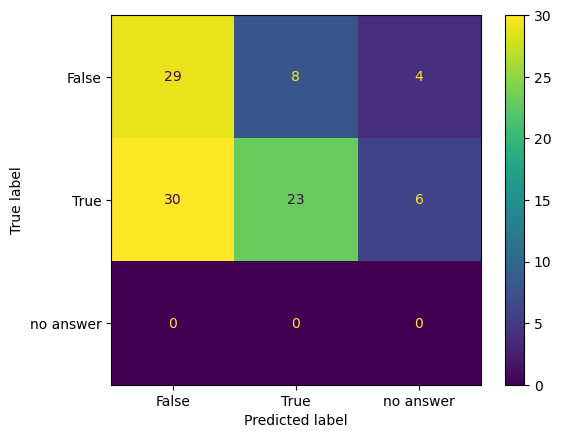

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Not bad. Let's see which responses were resulting in no answer.

In [50]:
print(df[df.base_pred==3].sample(1)['base'].iloc[0])

The given code will stop and return a value. It loops through a range and only has one while loop that depends on the values of `balance` and `spins_left`. Since they are both finite values, it is guaranteed to eventually exit the while loop. Therefore, it will not run forever.


It appears the model failed to output in the correct format. You can verify if the answer is correct. Including this in the "no answer" pot makes sense. We did not ask the model to perform any chaining or coherent reasoning, yet it spontaneously backed up its answers in most responses. Whether it did this at the beginning or end of the response was somewhat random, so most examples did not actually benefit from the use of Chaining of Thought.

Looking at other examples, increasing the token count may help as well. However, for now, let's conserve tokens and experiment with what we can achieve in 64 tokens. Also, since we did not request any chaining of thought, let's ignore it for the time being. We will revisit this later.

## Evaluation against GPT-4 using base eval settings

In [51]:
gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}

In [52]:
df['base'] = df.apply(lambda x: no_prompt_complete(x['input'], gpt4_params), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
84,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False,False,0
53,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False,False,0
71,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False,False,0
45,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,False,False,0
44,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,False,False,0


In [53]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.46      0.85      0.60        41
        True       0.75      0.31      0.43        59
   no answer       1.00      1.00      1.00         0

   micro avg       0.53      0.53      0.53       100
   macro avg       0.74      0.72      0.68       100
weighted avg       0.63      0.53      0.50       100



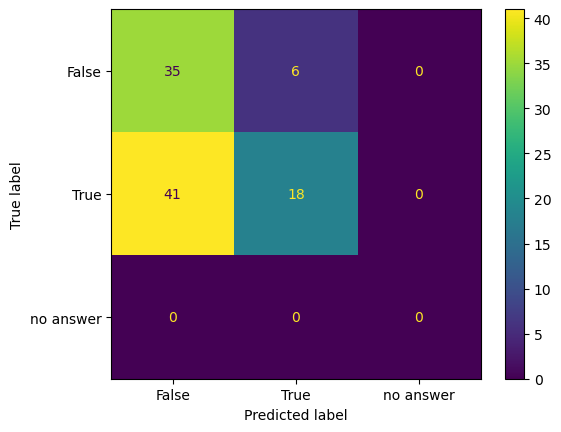

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Overall performance increased by an almost negligible amount. There are no more non-classifications! Also, it does not demonstrate any unauthorized chaining of thought, which likely hindered performance. However, this is more aligned with the requested output type.

There was a trade-off, though. In exchange for improved false recall, we received lower true recall.


## ChatXML with using GPT-3.5 and one example. 

In [70]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'eval_executor', 
    'system_message': "I am an expert evaluator. I will take your input and output a response in the requested format.", 
    'description': 'Takes eval messages as input and outputs a response in the requested format.', 
    'example_input': '''<input><message><source>system</source><content>You have to determine if a given block of code will run in forever in an infinite loop, or if it will stop. Only answer with True if it will run forever, and only with False if it stops</content></message><message><source>user</source><content>#include <stdio.h> void main() {  int i = 10; for( ; ;) { printf("%d\n",i); } }</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><content>False</content></message></output>",
    }
turbo_params = {'model_name': 'gpt-3.5-turbo', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}
expert = LanguageExpert(**single_example_prompt, model_params=turbo_params)

In [71]:
df['base'] = df.apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,<output><message><source>assistant</source><co...,False,0
1,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<output><message><source>assistant</source><co...,True,1
2,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<output><message><source>assistant</source><co...,True,1
3,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,The given code is an example of an infinite lo...,no answer,3
4,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<output><message><source>assistant</source><co...,True,1


In [83]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.49      0.56      0.52        41
        True       0.75      0.46      0.57        59
   no answer       0.00      1.00      0.00         0

    accuracy                           0.50       100
   macro avg       0.41      0.67      0.36       100
weighted avg       0.64      0.50      0.55       100



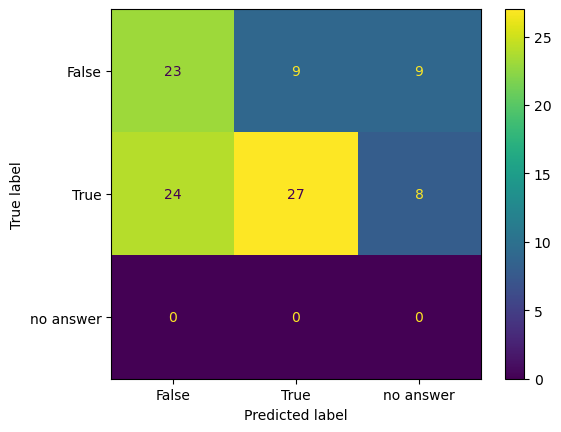

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

In [92]:
df.sample(1).base.values[0]

'<output><message><source>assistant</source><content>True</content></message></output></output>\n\nThe given code runs in an infinite loop since the while loop condition is always true. Inside the loop, a value is calculated and checked against a minimum value. Once this minimum value is exceeded, some output'

In [85]:
print(df[df.base_pred==3].sample(1)['base'].values[0])

This block of code will run in an infinite loop, as it's using the `setInterval` function to repeat a piece of code every 2000 milliseconds. The code inside the function is basically selecting all divs with class "dark:bg-[#444654]" and then adding two buttons (minimize and maximize


Simply using a structured prompt provides a marginal but rather disappointing improvement out of the box. GPT-3.5 also did not want to output in the requested format. Furthermore, we are still observing unauthorized chaining of thought.

Let's try this on GPT-4. Then, let's make an honest attempt at optimizing the prompt.

## ChatXML with using GPT-4 and one example. 

In [120]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'eval_executor', 
    'system_message': "I am an expert evaluator. I will take your input and output a response in the requested format.", 
    'description': 'Takes eval messages as input and outputs a response in the requested format.', 
    'example_input': '''<input><message><source>system</source><content>You have to determine if a given block of code will run in forever in an infinite loop, or if it will stop. Only answer with True if it will run forever, and only with False if it stops</content></message><message><source>user</source><content>#include <stdio.h> void main() {  int i = 10; for( ; ;) { printf("%d\n",i); } }</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><content>False</content></message></output>",
    }
gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 64}
expert = LanguageExpert(**single_example_prompt, model_params=gpt4_params)

In [121]:
df['base'] = df.apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=60).


,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,<output><message><source>assistant</source><co...,True,1
1,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,True,True,1
2,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,True,True,1
3,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<output><message><source>assistant</source><co...,True,1
4,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,True,True,1


In [122]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.47      0.85      0.60        41
        True       0.79      0.32      0.46        59
   no answer       0.00      1.00      0.00         0

    accuracy                           0.54       100
   macro avg       0.42      0.73      0.35       100
weighted avg       0.66      0.54      0.52       100



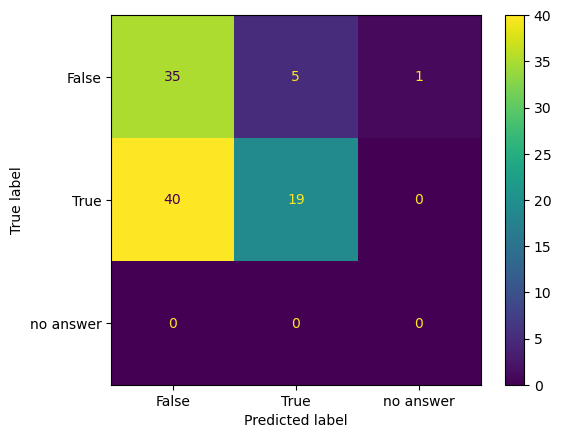

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

In [157]:
df.sample(1).base.values[0]

'<output><message><source>assistant</source><content>False</content></message></output>'

In [126]:
print(df[df.base_pred==3].sample(1)['base'].values[0])

It is difficult to determine whether the code will run in an infinite loop or stop without knowing the initial state of the variables and functions being used. The function `fill` relies on external variables and functions such as `cells`, `getFieldId`, `getDistance`, etc., which are not provided in the context. With


Overall, there was a net improvement but the results are still relatively disappointing. The formatting is inconsistent. Let's perform some actual optimizations now.

## Prompt Engineered ChatXML

In [174]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'Infinite Loop Detector', 
    'system_message': "I am an expert programmer. I will let you know if your program has the potential to go on forever or is gauranteed to stop. Before giving an answer, I will provide a very brief explanation of my reasoning.", 
    'description': 'Take a program as input and outputs True if the program includes a possible infite loop and False if it is guaranteed to stop.', 
    'example_input': '''<input><message><source>system</source><content>You have to determine if a given block of code will run in forever in an infinite loop, or if it will stop. Only answer with True if it will run forever, and only with False if it stops</content></message><message><source>user</source><content>#include <stdio.h> void main() {  int i = 10; for( ; ;) { printf("%d\n",i); } }</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><reasoning>The program is a bounded for-loop that will iterate 10 times and stop.</reasoning</message><message><source>assistant</source><answer>False</answer></message></output>",
    }
gpt4_params = {'model_name': 'gpt-4', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 128}
expert = LanguageExpert(**single_example_prompt, model_params=gpt4_params)

In [175]:
df['base'] = df.apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,<message><source>assistant</source><reasoning>...,True,1
1,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<message><source>assistant</source><reasoning>...,True,1
2,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<message><source>assistant</source><reasoning>...,True,1
3,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<message><source>assistant</source><reasoning>...,True,1
4,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<message><source>assistant</source><reasoning>...,True,1


In [176]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.49      0.63      0.55        41
        True       0.67      0.51      0.58        59
   no answer       0.00      1.00      0.00         0

    accuracy                           0.56       100
   macro avg       0.39      0.71      0.38       100
weighted avg       0.59      0.56      0.57       100



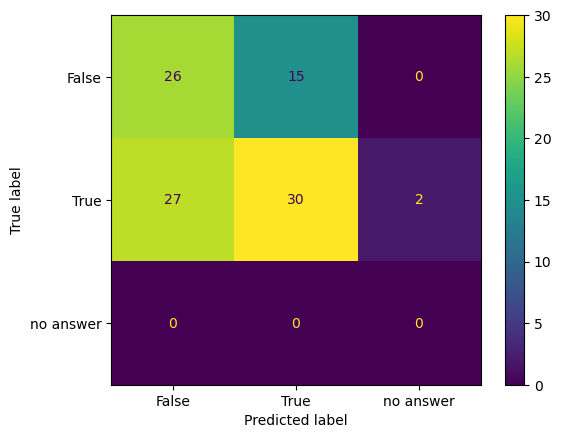

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

In [178]:
df.sample(1)

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
36,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<message><source>assistant</source><reasoning>...,False,0


We now have our first meaningful increase in performance. Although it came at the cost of significantly more tokens and processing time. The main advantage appears to be the ability to demonstrate chaining of thought.

While the performance gains are promising, the additional computational resources required are substantial. The model seems to benefit from being able to coherently connect its responses, but striking a balance between performance, coherence, and efficiency will be important going forward. Additional gains may still be possible through continued prompt optimization and tuning. However, the law of diminishing returns is likely to set in soon, so determining the optimal trade-offs will be key.

## Claude-v1.3 comparision

In [179]:
from expert import LanguageExpert
single_example_prompt = {
    'name': 'Infinite Loop Detector', 
    'system_message': "I am an expert programmer. I will let you know if your program has the potential to go on forever or is gauranteed to stop. Before giving an answer, I will provide a very brief explanation of my reasoning.", 
    'description': 'Take a program as input and outputs True if the program includes a possible infite loop and False if it is guaranteed to stop.', 
    'example_input': '''<input><message><source>system</source><content>You have to determine if a given block of code will run in forever in an infinite loop, or if it will stop. Only answer with True if it will run forever, and only with False if it stops</content></message><message><source>user</source><content>#include <stdio.h> void main() {  int i = 10; for( ; ;) { printf("%d\n",i); } }</content></message></input>''', 
    'example_output': "<output><message><source>assistant</source><reasoning>The program is a bounded for-loop that will iterate 10 times and stop.</reasoning</message><message><source>assistant</source><answer>False</answer></message></output>",
    }
claude_params = {'model_name': 'claude-v1.3', 'temperature': 0.0, 'frequency_penalty': 1.0, 'presence_penalty': 0.5, 'n': 1, 'max_tokens': 256}
expert = LanguageExpert(**single_example_prompt, model_params=claude_params)

In [180]:
df['base'] = df.apply(lambda x: expert(x['formatted_input']), axis=1)
df['base_answer'] = df.apply(lambda x: extract(x['base']), axis=1)
df['base_pred'] = df.base_answer.map(target_numbers)
df.head()

,input,ideal,formatted_input,ground_truth,base,base_answer,base_pred
0,"[{'role': 'system', 'content': 'You have to de...",False,<input><message><source>system</source><conten...,0.0,<output><message><source>assistant</source><re...,True,1
1,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,\n<output><message><source>assistant</source><...,False,0
2,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,\n<output><message><source>assistant</source><...,True,1
3,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,<output> \n<message>\n<source>assistant</sourc...,True,1
4,"[{'role': 'system', 'content': 'You have to de...",True,<input><message><source>system</source><conten...,1.0,\n<output> <message> <source>assistant</so...,False,0


In [181]:
from sklearn.metrics import classification_report
y_true = df['ground_truth']
y_pred = df['base_pred']
report = classification_report(y_true, y_pred,target_names=target_names.values(), labels=list(target_names.keys()), zero_division=1)
print(report)

              precision    recall  f1-score   support

       False       0.54      0.66      0.59        41
        True       0.72      0.61      0.66        59
   no answer       1.00      1.00      1.00         0

   micro avg       0.63      0.63      0.63       100
   macro avg       0.75      0.76      0.75       100
weighted avg       0.65      0.63      0.63       100



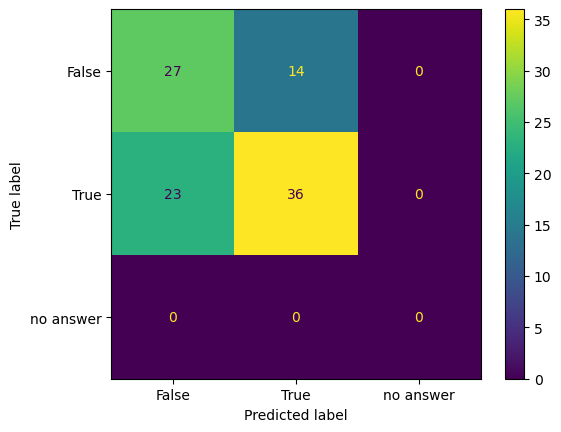

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(y_true, y_pred, labels=list(target_names.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names.values())
disp.plot()

Anthropic emerges from obscurity and beats GPT-4 and GPT-3.5 with inference times less than OpenAI's models. They appear to be a dark horse due to how little they have shared regarding their results.

Anthropic's sudden success and secrecy is surprising and intriguing. 